# 1

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

👆

为什么一定要换成`list`, 直接`dataset`不好吗?

## 1.1

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

就是:

$$
[3072 \times 1024, 1024 \times 512, 512 \times 128, 128 \times 2, 1024, 512, 128, 2]
$$


In [7]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

👆

这两段说明参数很多, LOL

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

这段代码创建了一个二维卷积层。

`nn.Conv2d(3, 16, kernel_size=3)` 这行代码的参数解释如下：

- `3` 是输入的通道数。在这个例子中，它是3，这意味着输入是一个彩色图像（红、绿、蓝三个通道）。
- `16` 是输出的通道数。这意味着这个卷积层将生成16个特征图（feature maps）。
- `kernel_size=3` 指定了卷积核的大小。在这个例子中，卷积核的大小是3x3。

输出 `Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))` 是这个卷积层的字符串表示。它告诉我们这个卷积层的一些参数：

- `3` 是输入的通道数。
- `16` 是输出的通道数。
- `kernel_size=(3, 3)` 是卷积核的大小。
- `stride=(1, 1)` 是卷积的步长。步长是卷积核在输入特征图上移动的步数。在这个例子中，步长是1，这意味着卷积核在水平和垂直方向上每次移动一步。

In [9]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [10]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

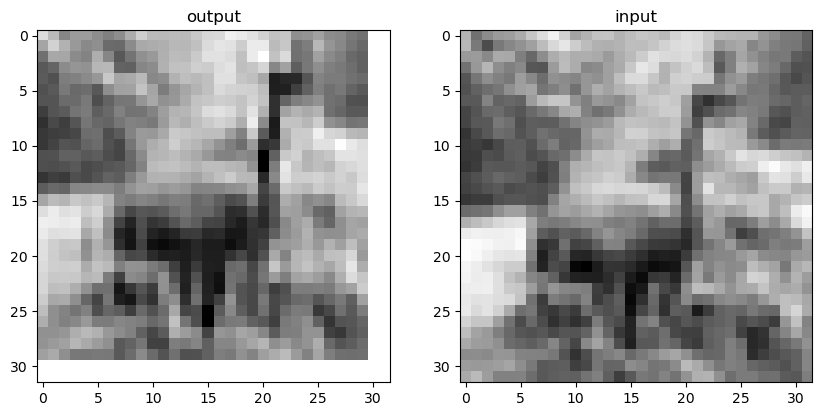

In [11]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [13]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

这段代码是在初始化一个卷积层的权重。`conv.weight.fill_(1.0 / 9.0)`这行代码将卷积层的权重全部填充为1/9。

为什么要填充为1/9呢？这通常是因为这个卷积层可能是一个3x3的卷积核，总共有9个元素。如果我们希望这个卷积核在初始状态下对输入进行平均池化（即，将3x3的区域内的值求平均），那么每个元素的权重应该是1/9。这样，当这个卷积核作用在一个3x3的区域上时，它会将该区域内的所有值加起来，然后乘以1/9，从而实现平均池化。

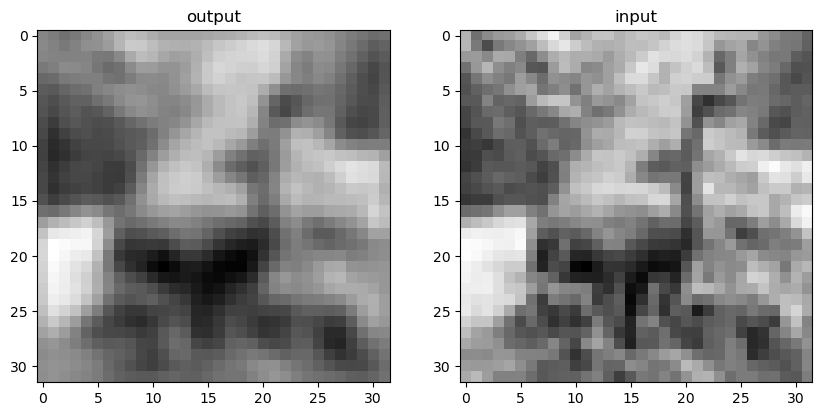

In [14]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

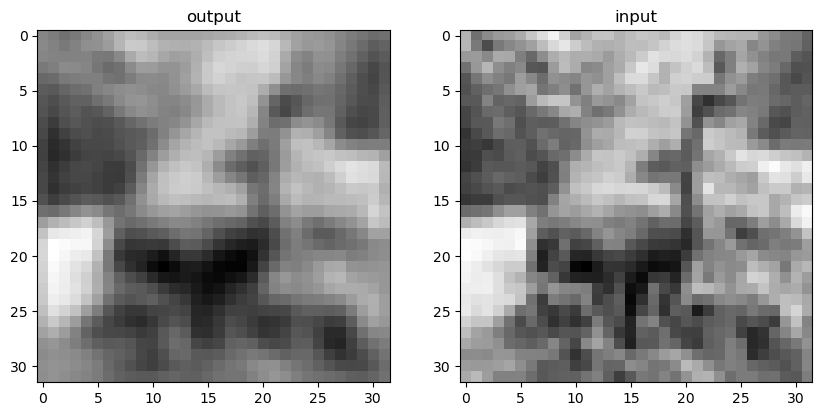

In [15]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

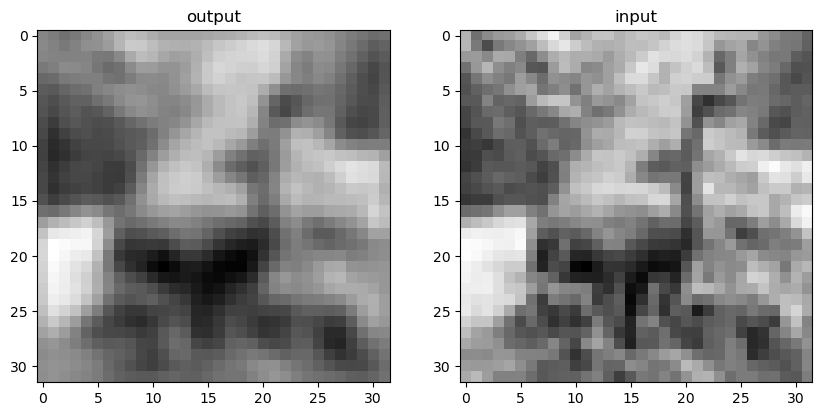

In [16]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [17]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [18]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [19]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [20]:
# model(img.unsqueeze(0))

这个错误是因为你在卷积层和全连接层之间没有正确地调整张量的形状。在全连接层（`nn.Linear`）之前，你需要将多维的张量展平为一维。

在你的模型中，最后一个`MaxPool2d`层输出的张量形状是`[batch_size, 8, height, width]`。然而，`nn.Linear`层期望的输入形状是`[batch_size, num_features]`，所以你需要添加一个展平操作。

你可以通过添加一个`nn.Flatten()`层来实现这一点，如下所示：

```python
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),  # 添加这一行
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))
```

在这个修改后的模型中，`nn.Flatten()`层将`[batch_size, 8, height, width]`形状的张量展平为`[batch_size, 8*height*width]`形状的张量，然后将其传递给`nn.Linear`层。

请注意，你可能需要根据你的输入图像的大小和你的卷积层的配置，调整`nn.Linear(8 * 8 * 8, 32)`中的`8 * 8 * 8`。这个值应该等于`nn.Flatten()`层输出的特征数量。

## 1.2

In [21]:
model1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Flatten(), 
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [22]:
model1(img.unsqueeze(0))

tensor([[ 0.0987, -0.0068]], grad_fn=<AddmmBackward0>)

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
model2 = Net()

# 创建一个映射，将nn.Sequential模型的参数键名映射到自定义Net模型的参数键名
key_map = {
    "0.weight": "conv1.weight",
    "0.bias": "conv1.bias",
    "3.weight": "conv2.weight",
    "3.bias": "conv2.bias",
    "7.weight": "fc1.weight",
    "7.bias": "fc1.bias",
    "9.weight": "fc2.weight",
    "9.bias": "fc2.bias",
}

# 获取nn.Sequential模型的state_dict
state_dict = model1.state_dict()

# 创建一个新的state_dict，其键名与自定义Net模型的键名相同
new_state_dict = {key_map[key]: value for key, value in state_dict.items() if key in key_map}

# 将新的state_dict加载到自定义Net模型中
model2.load_state_dict(new_state_dict)

model2

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [25]:
model2(img.unsqueeze(0))

tensor([[ 0.0987, -0.0068]], grad_fn=<AddmmBackward0>)

👆

---

**出现结果不同!!!!**

> 结果不同, 为什么?

虽然这两个模型在结构上是相同的, 但是他们的权重初始化可能是不同的. 在PyTorch中, 每次你创建一个新的`nn.Module`（包括`nn.Sequential`和自定义模型）, 它的权重都会被随机初始化. 因此, 即使两个模型的结构完全相同, 他们的权重也可能是不同的, 除非你明确地设置了相同的随机种子或者手动将一个模型的权重复制到另一个模型. 

此外, 如果你在两个模型之间运行了任何训练代码, 那么这也可能改变模型的权重, 从而导致不同的输出. 

如果你希望两个模型有相同的输出, 你需要确保他们有相同的权重. 你可以通过以下方式来实现这一点: 

```python
# 创建第一个模型
model1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(), 
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

# 创建第二个模型, 并将第一个模型的权重复制到第二个模型
model2 = Net()
model2.load_state_dict(model1.state_dict())
```

在这段代码中, `model2.load_state_dict(model1.state_dict())`将`model1`的权重复制到`model2`. 现在, 只要输入相同, `model1`和`model2`的输出就应该是相同的.

> P.S.
>
> 但是再这段代码中, 并不能简单用`model2.load_state_dict(model1.state_dict())`, 这会出现如下报错信息:
>
> ```
> RuntimeError: Error(s) in loading state_dict for Net:
> 	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
> 	Unexpected key(s) in state_dict: "0.weight", "0.bias", "3.weight", "3.bias", "7.weight", "7.bias", "9.weight", "9.bias". 
> ```
> 
> 由此, 我们需要将代码修改为:
>
> ```python
> # 创建一个映射，将nn.Sequential模型的参数键名映射到自定义Net模型的参数键名
> key_map = {
>     "0.weight": "conv1.weight",
>     "0.bias": "conv1.bias",
>     "3.weight": "conv2.weight",
>     "3.bias": "conv2.bias",
>     "7.weight": "fc1.weight",
>     "7.bias": "fc1.bias",
>     "9.weight": "fc2.weight",
>     "9.bias": "fc2.bias",
> }
> 
> # 获取nn.Sequential模型的state_dict
> state_dict = model1.state_dict()
> 
> # 创建一个新的state_dict，其键名与自定义Net模型的键名相同
> new_state_dict = {key_map[key]: value for key, value in state_dict.items() if key in key_map}
> 
> # 将新的state_dict加载到自定义Net模型中
> model2.load_state_dict(new_state_dict)
> ```

---

同时, 值得一提的是: 这两段代码在功能上是等价的, 都定义了一个具有两个卷积层和两个全连接层的卷积神经网络. 他们的主要区别在于实现方式: 第一段代码使用了`nn.Sequential`, 而第二段代码使用了自定义的`nn.Module`. 

`nn.Sequential`是一个特殊的模块, 它包含了其他模块, 并按照它们被添加的顺序来执行它们. 这使得网络的定义变得简单, 但是也限制了模型的灵活性. 例如, 你不能在`nn.Sequential`模型中包含有多个输入或输出的层, 或者有复杂控制流的层. 

自定义的`nn.Module`提供了更大的灵活性. 你可以在`forward`方法中定义任意的计算流程, 包括有多个输入或输出的层, 有复杂控制流的层, 等等. 

如果你的模型的结构比较简单, 你可以使用`nn.Sequential`来简化代码. 如果你的模型的结构比较复杂, 你可能需要使用自定义的`nn.Module`. 

In [26]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model3 = Net()

model3.load_state_dict(new_state_dict)

model3(img.unsqueeze(0))

tensor([[ 0.0987, -0.0068]], grad_fn=<AddmmBackward0>)

👆

这是同一个目的的第三章实现方式!

## 1.3

In [28]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

print(f"Training on device: {device}.")

Training on device: cuda.


In [29]:
import datetime

In [30]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        
        # 损失初始化
        loss_train = 0.0
        loss_val = 0.0

        for imgs, labels in train_loader:  # 每次循环一个batch

            # 预测 ...
            outputs = model(imgs)  # 前向传播
            loss = loss_fn(outputs, labels) # 用结果和labels计算损失

            # 梯度
            optimizer.zero_grad() # 梯度初始化为0
            loss.backward() # 反向传播计算梯度
            optimizer.step()

            loss_train += loss.item() # 累加损失

        for imgs_val, labels_val in val_loader:

            outputs_val = model(imgs_val)
            loss_part_val = loss_fn(outputs_val, labels_val)
            loss_val += loss_part_val.item()

        if epoch == 1 or epoch % 10 == 0: # 对于第1个和每10个epoch
            print('{} Epoch {}, Training loss {}, Validation loss {}'
                  .format(
                        datetime.datetime.now(), epoch,
                        loss_train / len(train_loader),
                        loss_val / len(val_loader)
                  ))

1. `if epoch == 1 or epoch % 10 == 0:`：这个条件判断语句是在每个训练周期（epoch）开始时执行。如果是第一个训练周期，或者是每10个训练周期，那么就执行下面的代码。
2. `print(...)`：这行代码打印出当前的**日期和时间**（`datetime.datetime.now()`），当前的**训练周期数**（`epoch`），以及**训练损失**（`loss_train / len(train_loader)`）和**验证损失**（`loss_val / len(val_loader)`）。训练损失和验证损失都是通过将总损失除以数据加载器（`train_loader` 或 `val_loader`）的长度来计算的，这样可以得到平均损失。
3. `.format(...)`
   1. `datetime.datetime.now()`：这是Python的datetime模块中的一个方法，它返回当前的日期和时间。这个值将替换字符串中的第一个`{}`。
   2. `epoch`：这是一个变量，代表当前的训练周期数。这个值将替换字符串中的第二个`{}`。
   3. `loss_train / len(train_loader)`：这是一个表达式，它计算的是平均训练损失。`loss_train`是训练损失的总和，`len(train_loader)`是训练数据的数量。这个值将替换字符串中的第三个`{}`。
   4. `loss_val / len(val_loader)`：这也是一个表达式，它计算的是平均验证损失。`loss_val`是验证损失的总和，`len(val_loader)`是验证数据的数量。这个值将替换字符串中的第四个`{}`。

In [31]:
# training on 'CPU'

train_loader_cpu = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) 
val_loader_cpu = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [32]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_cpu,
    val_loader = val_loader_cpu
)

2024-02-02 22:55:12.224493 Epoch 1, Training loss 0.5708008514847726, Validation loss 0.4952299017459154
2024-02-02 22:55:24.567238 Epoch 10, Training loss 0.3339461323561942, Validation loss 0.334935886785388
2024-02-02 22:55:37.937178 Epoch 20, Training loss 0.2962817868609337, Validation loss 0.3206206406466663
2024-02-02 22:55:51.874789 Epoch 30, Training loss 0.2695326501396811, Validation loss 0.3070549173280597
2024-02-02 22:56:05.036258 Epoch 40, Training loss 0.2450622946593412, Validation loss 0.2783084693364799
2024-02-02 22:56:18.749505 Epoch 50, Training loss 0.22623928574619778, Validation loss 0.2743891696445644
2024-02-02 22:56:31.993252 Epoch 60, Training loss 0.2118130373252425, Validation loss 0.3356199781410396
2024-02-02 22:56:45.576044 Epoch 70, Training loss 0.19751943666843852, Validation loss 0.3067998685874045
2024-02-02 22:56:58.476642 Epoch 80, Training loss 0.18407775736918117, Validation loss 0.2766256108880043
2024-02-02 22:57:11.388376 Epoch 90, Training

In [33]:
# training on 'GPU'

def training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.to(device)
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        loss_val = 0.0

        for imgs, labels in train_loader:
            
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        for imgs_val, labels_val in val_loader:
            
            imgs_val = imgs_val.to(device=device)
            labels_val = labels_val.to(device=device)

            outputs_val = model(imgs_val)
            loss_part_val = loss_fn(outputs_val, labels_val)
            loss_val += loss_part_val.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, Validation loss {}'
                  .format(
                        datetime.datetime.now(), epoch,
                        loss_train / len(train_loader),
                        loss_val / len(val_loader)
                  ))

In [34]:
model = Net().to(device=device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [35]:
training_loop_gpu(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_cpu,
    val_loader = val_loader_cpu
)

2024-02-02 22:57:27.224285 Epoch 1, Training loss 0.5622410339534663, Validation loss 0.48701615910977125
2024-02-02 22:57:31.061960 Epoch 10, Training loss 0.33046229022323703, Validation loss 0.3458774769678712
2024-02-02 22:57:35.236162 Epoch 20, Training loss 0.2957916582465931, Validation loss 0.31741571007296443
2024-02-02 22:57:39.979502 Epoch 30, Training loss 0.2706524693662194, Validation loss 0.2989501412957907
2024-02-02 22:57:44.684737 Epoch 40, Training loss 0.25231395453024824, Validation loss 0.2863029963336885
2024-02-02 22:57:49.421751 Epoch 50, Training loss 0.2320837667983049, Validation loss 0.2842944199219346
2024-02-02 22:57:54.076246 Epoch 60, Training loss 0.21709358810809007, Validation loss 0.31090026814490557
2024-02-02 22:57:58.442784 Epoch 70, Training loss 0.2035268672332642, Validation loss 0.2888598311692476
2024-02-02 22:58:02.777900 Epoch 80, Training loss 0.1880716416676333, Validation loss 0.3061237307265401
2024-02-02 22:58:07.091359 Epoch 90, Trai

In [36]:
# training on 'GPU' - A FASTER VERSION

cifar2_gpu = [(
    img.to(device=device),
    torch.tensor(label).to(device=device)
    )
    for img, label in cifar2
]

cifar2_val_gpu = [(
    img.to(device=device),
    torch.tensor(label).to(device=device)
    )
    for img, label in cifar2_val
]

In [37]:
train_loader_gpu = torch.utils.data.DataLoader(cifar2_gpu, batch_size=64, shuffle=True)
val_loader_gpu = torch.utils.data.DataLoader(cifar2_val_gpu, batch_size=64, shuffle=False)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [38]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_gpu,
    val_loader = val_loader_gpu
)

2024-02-02 22:58:13.022352 Epoch 1, Training loss 0.5560002585125577, Validation loss 0.4881948297843337
2024-02-02 22:58:16.391630 Epoch 10, Training loss 0.33039212805829987, Validation loss 0.4265469694510102
2024-02-02 22:58:20.126913 Epoch 20, Training loss 0.29642911729918925, Validation loss 0.3416355806402862
2024-02-02 22:58:24.222123 Epoch 30, Training loss 0.2737994971358852, Validation loss 0.3140600877813995
2024-02-02 22:58:28.047544 Epoch 40, Training loss 0.2514147369345282, Validation loss 0.29640528839081526
2024-02-02 22:58:31.811058 Epoch 50, Training loss 0.2320627171997052, Validation loss 0.3232989157550037
2024-02-02 22:58:35.496420 Epoch 60, Training loss 0.21455770579113323, Validation loss 0.33668801560997963
2024-02-02 22:58:39.048789 Epoch 70, Training loss 0.1996301571559754, Validation loss 0.3489159750752151
2024-02-02 22:58:42.596496 Epoch 80, Training loss 0.1850656069055864, Validation loss 0.3190877861343324
2024-02-02 22:58:46.815970 Epoch 90, Train

## 1.4

In [39]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [40]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 16, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 16)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

修改, 增加模型的宽度, $ 16 \to 32 $

In [41]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# loss_fn = nn.CrossEntropyLoss()

👆

当重新定义`model`时, 需要将`model`重新传递给`optimizer`

In [42]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_gpu,
    val_loader = val_loader_gpu
)

2024-02-02 22:58:51.766412 Epoch 1, Training loss 0.5425846117317297, Validation loss 0.4745121244341135
2024-02-02 22:58:56.288055 Epoch 10, Training loss 0.32138324135048374, Validation loss 0.3301450666040182
2024-02-02 22:59:01.070096 Epoch 20, Training loss 0.2772475232364266, Validation loss 0.3011070233769715
2024-02-02 22:59:05.601150 Epoch 30, Training loss 0.2420189292377727, Validation loss 0.2917784973978996
2024-02-02 22:59:10.035102 Epoch 40, Training loss 0.21353359444505848, Validation loss 0.269878493854776
2024-02-02 22:59:14.350426 Epoch 50, Training loss 0.18918596649435676, Validation loss 0.2658270827960223
2024-02-02 22:59:18.870287 Epoch 60, Training loss 0.16647480086536165, Validation loss 0.28409657580778
2024-02-02 22:59:23.291218 Epoch 70, Training loss 0.1449606773579956, Validation loss 0.30459499824792147
2024-02-02 22:59:27.678779 Epoch 80, Training loss 0.12313474309007832, Validation loss 0.27214027056470513
2024-02-02 22:59:32.327559 Epoch 90, Traini

👆

明显`overfitting`了.

## 1.5

In [43]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_val = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        for imgs_val, labels_val in val_loader:
            imgs_val = imgs_val.to(device=device)
            labels_val = labels_val.to(device=device)
            outputs_val= model(imgs_val)
            loss_val = loss_fn(outputs_val, labels_val)
            loss_val += loss_val.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, Validation loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader),
                loss_val / len(val_loader)))


In [44]:
train_loader_l2reg = torch.utils.data.DataLoader(cifar2_gpu, batch_size=64, shuffle=True) 
val_loader_l2reg = torch.utils.data.DataLoader(cifar2_val_gpu, batch_size=64, shuffle=False)

In [45]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [46]:
training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_l2reg,
    val_loader = val_loader_l2reg
)

2024-02-02 22:59:37.388469 Epoch 1, Training loss 0.5746070431296233, Validation loss 0.029127376154065132
2024-02-02 22:59:43.546621 Epoch 10, Training loss 0.347790092989138, Validation loss 0.03040698543190956
2024-02-02 22:59:50.700901 Epoch 20, Training loss 0.30990747822697756, Validation loss 0.03201809152960777
2024-02-02 22:59:57.552233 Epoch 30, Training loss 0.28188107978955956, Validation loss 0.028734970837831497
2024-02-02 23:00:04.842515 Epoch 40, Training loss 0.2564145565792254, Validation loss 0.03454948216676712
2024-02-02 23:00:11.438060 Epoch 50, Training loss 0.23506482420073951, Validation loss 0.037262219935655594
2024-02-02 23:00:18.031940 Epoch 60, Training loss 0.2153054825059927, Validation loss 0.03996533527970314
2024-02-02 23:00:24.829680 Epoch 70, Training loss 0.20051155623736655, Validation loss 0.036543797701597214
2024-02-02 23:00:31.309457 Epoch 80, Training loss 0.18586423717866277, Validation loss 0.038817085325717926
2024-02-02 23:00:37.781505 Ep

效果有所改善, 但是还是不甚理想, 下面再试试`dropout`

In [47]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_l2reg,
    val_loader = val_loader_l2reg
)

2024-02-02 23:00:45.220652 Epoch 1, Training loss 0.6035494508257337, Validation loss 0.026127593591809273
2024-02-02 23:00:51.604965 Epoch 10, Training loss 0.4137348914222353, Validation loss 0.030379068106412888
2024-02-02 23:00:58.216096 Epoch 20, Training loss 0.37843249349077795, Validation loss 0.022808367386460304
2024-02-02 23:01:04.791285 Epoch 30, Training loss 0.3620213681155709, Validation loss 0.03307093679904938
2024-02-02 23:01:11.839709 Epoch 40, Training loss 0.3425910561137898, Validation loss 0.03351103141903877
2024-02-02 23:01:18.847853 Epoch 50, Training loss 0.33015450749807296, Validation loss 0.023994004353880882
2024-02-02 23:01:25.785003 Epoch 60, Training loss 0.316511938051813, Validation loss 0.027433497831225395
2024-02-02 23:01:34.444698 Epoch 70, Training loss 0.3116909837836673, Validation loss 0.028631899505853653
2024-02-02 23:01:44.679654 Epoch 80, Training loss 0.29564610218546195, Validation loss 0.028141336515545845
2024-02-02 23:01:52.072503 Ep

In [49]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [50]:
temp = validate(model, train_loader_l2reg, val_loader_l2reg)

Accuracy train: 0.90
Accuracy val: 0.88


In [51]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [52]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_l2reg,
    val_loader = val_loader_l2reg
)

2024-02-02 23:02:04.643855 Epoch 1, Training loss 0.5237614123304938, Validation loss 0.03154312074184418
2024-02-02 23:02:11.957953 Epoch 10, Training loss 0.34961854376990326, Validation loss 0.024021342396736145
2024-02-02 23:02:20.655700 Epoch 20, Training loss 0.3004418405567765, Validation loss 0.017988858744502068
2024-02-02 23:02:30.109881 Epoch 30, Training loss 0.2556390512710924, Validation loss 0.021829521283507347
2024-02-02 23:02:38.374158 Epoch 40, Training loss 0.2199271302314321, Validation loss 0.008360611274838448
2024-02-02 23:02:46.773119 Epoch 50, Training loss 0.19288016105913053, Validation loss 0.011521680280566216
2024-02-02 23:02:55.475066 Epoch 60, Training loss 0.16661947642921643, Validation loss 0.011796838603913784
2024-02-02 23:03:03.877747 Epoch 70, Training loss 0.15302013938024545, Validation loss 0.013003501109778881
2024-02-02 23:03:12.221270 Epoch 80, Training loss 0.144280414814782, Validation loss 0.008738027885556221
2024-02-02 23:03:20.605466 

In [53]:
temp = validate(model, train_loader_l2reg, val_loader_l2reg)

Accuracy train: 0.99
Accuracy val: 0.89


## 1.6

In [56]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [57]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_l2reg,
    val_loader = val_loader_l2reg
)

2024-02-02 23:06:35.016064 Epoch 1, Training loss 0.6626764420111468, Validation loss 0.033441461622714996
2024-02-02 23:06:41.746170 Epoch 10, Training loss 0.3627097570592431, Validation loss 0.028387676924467087
2024-02-02 23:06:48.971982 Epoch 20, Training loss 0.3269421646169796, Validation loss 0.02311667613685131
2024-02-02 23:06:56.178780 Epoch 30, Training loss 0.29307958274889906, Validation loss 0.02272788994014263
2024-02-02 23:07:04.202436 Epoch 40, Training loss 0.2683913201852969, Validation loss 0.03528887778520584
2024-02-02 23:07:12.276506 Epoch 50, Training loss 0.24330535891709054, Validation loss 0.025333290919661522
2024-02-02 23:07:19.822722 Epoch 60, Training loss 0.22222803917470252, Validation loss 0.025959253311157227
2024-02-02 23:07:27.287402 Epoch 70, Training loss 0.20004560793661008, Validation loss 0.03337766230106354
2024-02-02 23:07:34.622954 Epoch 80, Training loss 0.1815308132179224, Validation loss 0.034435294568538666
2024-02-02 23:07:41.913411 Ep

In [58]:
temp = validate(model, train_loader_l2reg, val_loader_l2reg)

Accuracy train: 0.97
Accuracy val: 0.90


In [59]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [60]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [61]:
model = NetResDeep(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_l2reg,
    val_loader = val_loader_l2reg
)

2024-02-02 23:09:34.038310 Epoch 1, Training loss 0.6228872628728296, Validation loss 0.04925315082073212
2024-02-02 23:09:55.397610 Epoch 10, Training loss 0.31379315114704665, Validation loss 0.022255806252360344
2024-02-02 23:10:18.161882 Epoch 20, Training loss 0.2175278065690569, Validation loss 0.03917260840535164
2024-02-02 23:10:39.779622 Epoch 30, Training loss 0.16407750798448636, Validation loss 0.05295901373028755
2024-02-02 23:11:02.995653 Epoch 40, Training loss 0.13180784368590945, Validation loss 0.0935051441192627
2024-02-02 23:11:27.391158 Epoch 50, Training loss 0.24243421060074666, Validation loss 0.041873153299093246
2024-02-02 23:11:50.848493 Epoch 60, Training loss 0.10346921087260459, Validation loss 0.053708598017692566
2024-02-02 23:12:14.567503 Epoch 70, Training loss 0.08178028208055314, Validation loss 0.06882832944393158
2024-02-02 23:12:38.806002 Epoch 80, Training loss 0.07634172612314771, Validation loss 0.06087283417582512
2024-02-02 23:13:02.817755 Ep

In [62]:
temp = validate(model, train_loader_l2reg, val_loader_l2reg)

Accuracy train: 1.00
Accuracy val: 0.89
